In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import datasets, layers, models
import os, random

from modules.painting import painting
from modules.database import database as db
# from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras import backend as K
from keras.applications import ResNet50

#### Control Variables

In [2]:
# setting path variables for Working Directory and folder to save and load
#   models from.
wd = os.getcwd()
WD_PATH =  os.path.abspath(wd)
PATH_TRAINING = os.path.join(WD_PATH, "model_training")

# # initializing the database object
gallery = db()

# Size of the pictures when reduced in size
PIXEL_SIZE = 256

# the proportions to split the available paintings in training
# and testing.
keep_unused = 10
prop_train = 0.8
prop_test = 0.2

# selection  of artists to use. (our ids)
# 3,4,10 = Pierre-Auguste Renoir, Francisco Goya, Paul Gauguin
artists = [1,2,3,4,5,6,7,8,9,10]
count_artists = len(artists)

# defining labels in a list
class_names = []
for k in artists:
    class_names.append(gallery.get_artist(k)[1])

In [3]:
# checking the available paintings per artist.
num_paintings = np.zeros(count_artists,np.int16)
for j in range(count_artists):
    num_paintings[j] = len(gallery.get_paintingids_from_artist(artists[j]))
print(num_paintings)
# Total number of paintings available
TOTAL_PAINTINGS = sum(num_paintings)

[877 439 336 291 259 239 702 262 255 311]


In [4]:
# Weights for the model:
class_temp = TOTAL_PAINTINGS / num_paintings
class_weights = {}
for i in range(count_artists):
    class_weights[i] = class_temp[i]
class_weights

{0: 4.5279361459521095,
 1: 9.045558086560364,
 2: 11.818452380952381,
 3: 13.646048109965635,
 4: 15.332046332046332,
 5: 16.615062761506277,
 6: 5.656695156695156,
 7: 15.15648854961832,
 8: 15.572549019607843,
 9: 12.768488745980708}

In [5]:
# coding the sizes needed as collection arrays for the input data
SIZE_P_TRAINING = 0
training_size_paintings = num_paintings.copy()
SIZE_P_TESTING = 0
testing_size_paintings = num_paintings.copy()
for i in range(count_artists):
    train_count = int((num_paintings[i] - keep_unused)  * prop_train)
    test_count = int((num_paintings[i] - keep_unused)  * prop_test)
    # print(sum((train_count,test_count,10)),training_size_paintings[i])
    SIZE_P_TRAINING += train_count
    SIZE_P_TESTING += test_count
    training_size_paintings[i] = train_count
    testing_size_paintings[i] = test_count
print("total train paintings:", SIZE_P_TRAINING)
print("total test paintings:", SIZE_P_TESTING)

total train paintings: 3092
total test paintings: 770


In [6]:
## creating arrays to hold the pictures taken from the DB
training_images = np.zeros((SIZE_P_TRAINING,PIXEL_SIZE,PIXEL_SIZE,3))
index_training = 0
skip_count_training = 0
testing_images = np.zeros((SIZE_P_TESTING,PIXEL_SIZE,PIXEL_SIZE,3))
index_testing = 0
skip_count_testing = 0
# creating the arrays to hold labels. In this case they are the artist ids.
training_labels = np.zeros((SIZE_P_TRAINING,count_artists),dtype=int)
testing_labels = np.zeros((SIZE_P_TESTING,count_artists),dtype=int)
unused_paintings = np.array(
    [0]*(TOTAL_PAINTINGS-SIZE_P_TESTING-SIZE_P_TRAINING)
    ,dtype=int)
# checking if the numbers add up.
print(training_images.shape)
print(testing_images.shape)
print(training_labels.shape)
print(testing_labels.shape)
print(unused_paintings.shape)

(3092, 256, 256, 3)
(770, 256, 256, 3)
(3092, 10)
(770, 10)
(109,)


In [7]:
# filling the arrays with picture arrays. They will be resized according
# to the pixel_size value
unused_index = 0
for i in range(count_artists):
    # loading all ids from the artist
    ids = gallery.get_paintingids_from_artist(artists[i])
    # shuffle the ids to get random order for selection
    random.seed(1983)
    random.shuffle(ids)
    print("New Artist")
    
    # getting the numbers for the current artist:
    _str = training_size_paintings[i]
    _ste = testing_size_paintings[i]
    # slicing the ids for training and testing of artist with id i+1
    ids_training = ids[ : _str]
    ids_testing = ids[_str : _str + _ste]
    ids_unused = ids[ _str + _ste : ]
    
    # collecting the ids of the unused paintings
    for l, f in zip(range(unused_index,unused_index+len(ids_unused))
                    , ids_unused):
        unused_paintings[l] = f[0]
    unused_index += len(ids_unused)
    
    # retrieving the paintings from the db, resizing them and collecting
    # them in the training_images array while also filling the labels
    for k in ids_training:
        temp_p = painting("local DB", id=k[0])
        temp_p_res = cv.resize(temp_p.ndarray, dsize=(PIXEL_SIZE,PIXEL_SIZE)
                               ,interpolation=cv.INTER_CUBIC)
        if temp_p_res.shape == (PIXEL_SIZE,PIXEL_SIZE,3):
            training_images[index_training] = temp_p_res
            training_labels[index_training,i] = 1
            index_training += 1
        else:
            skip_count_training += 1
            
    # retrieving the paintings from the db, resizing them and collecting
    # them in the testing_images array while also filling the labels
    for j in ids_testing:
        temp_p = painting("local DB", id=j[0])
        temp_p_res = cv.resize(temp_p.ndarray, dsize=(PIXEL_SIZE,PIXEL_SIZE)
                               ,interpolation=cv.INTER_CUBIC)
        if temp_p_res.shape == (PIXEL_SIZE,PIXEL_SIZE,3):
            testing_images[index_testing] = temp_p_res
            testing_labels[index_testing,i] = 1
            index_testing += 1
        else:
            skip_count_testing += 1

# ## dropping the last few array positions of testing images, which where 
# ## not filled.
testing_images = testing_images[:index_testing,:,:,:]
testing_labels = testing_labels[:index_testing,:]
# ## dropping the last few array positions of training images, which where 
# ## not filled.
training_images = training_images[:index_training,:,:,:]
training_labels = training_labels[:index_training,:]

# # the pixels on an image are rescaled from 0-255 to 0-1 
training_images, testing_images = training_images/255, testing_images/255 

New Artist
New Artist
New Artist
New Artist
New Artist
New Artist
New Artist
New Artist
New Artist
New Artist


In [8]:
# shuffeling all input data.
index_testing = list(range(testing_images.shape[0]))
index_training = list(range(training_images.shape[0]))
random.seed(1983)
random.shuffle(index_testing)
testing_images_shuffled = testing_images.copy()
testing_labels_shuffled = testing_labels.copy()
for i,j in zip(index_testing, range(testing_images.shape[0])):
    testing_images_shuffled[i] = testing_images[j]
    testing_labels_shuffled[i] = testing_labels[j]

random.shuffle(index_training)
training_images_shuffled = training_images.copy()
training_labels_shuffled = training_labels.copy()
for i,j in zip(index_training, range(training_images.shape[0])):
    training_images_shuffled[i] = training_images[j]
    training_labels_shuffled[i] = training_labels[j]

#### Checking data shapes

In [9]:
print(training_images.shape)
print(testing_images.shape)
print(training_labels.shape)
print(testing_labels.shape)
print(type(training_labels[185:200]))

(2999, 256, 256, 3)
(746, 256, 256, 3)
(2999, 10)
(746, 10)
<class 'numpy.ndarray'>


In [10]:
print(training_labels[500:510])

[[1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]]


In [11]:
# print(np.unique(training_labels))
# print(type(training_labels[21]))
# print(training_labels[21].shape)
# print(training_labels[500])
# print(training_labels[:,0].shape)
# print(type(training_labels[:,0]))

In [12]:
model = Sequential()
model.add(Conv2D(32, (2, 2), input_shape=(PIXEL_SIZE,PIXEL_SIZE,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
 
model.add(Conv2D(32, (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
 
model.add(Conv2D(64, (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
 
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

In [13]:
## different version
model = Sequential()
model.add(Conv2D(64,(3,3),padding='same',input_shape=(PIXEL_SIZE, PIXEL_SIZE , 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128,(3 , 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Flatten ())
  
## fully connected layer
for i in range(0):
    units=256//(i+1)
    if units<32:
        break
    
    if i ==0:
        input_dim=model.output_shape[1]
        
    else:
        input_dim=units
        
    print(input_dim)
    
    # Add the Dense Layer along with activation and batch normalization
    
    dense_layer=Dense(units=units,input_dim=input_dim,)
    
    # Add the Leaky ReLU activation layer
    
    dense_layer=Dense(units=64,input_dim=model.output_shape[1])
    activation_layer=Activation('relu')
    batch_norm_layer = BatchNormalization()
    model.add(dense_layer)
    model.add(activation_layer)
    model.add(batch_norm_layer)
   
## Add Dropout Layer
dropout_fraction=0.5
dropout_layer=Dropout(dropout_fraction)

## Add the dense layer for final output
dense_output=Dense(units=count_artists, input_dim=model.output_shape[1], activation='softmax')
# activation_output = Activation('sigmoid')

model.add(dropout_layer)
model.add(dense_output)

In [14]:
opt = Adam(learning_rate=0.001) # learning rate

# Compile the Model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
history = model.fit(training_images_shuffled,training_labels_shuffled
                    ,batch_size=64
                    ,epochs=3
                    ,validation_data=(testing_images,testing_labels)
                    , class_weight= class_weights)

Epoch 1/3
47/47 [==============================] - 407s 8s/step - loss: 2008.1523 - accuracy: 0.3264 - val_loss: 46.2490 - val_accuracy: 0.1247
Epoch 2/3
47/47 [==============================] - 396s 8s/step - loss: 624.1013 - accuracy: 0.5228 - val_loss: 52.6614 - val_accuracy: 0.1099
Epoch 3/3
47/47 [==============================] - 388s 8s/step - loss: 153.9908 - accuracy: 0.7516 - val_loss: 39.9023 - val_accuracy: 0.0992


In [16]:
loss,accuracy = model.evaluate(testing_images, testing_labels)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

24/24 [==============================] - 19s 768ms/step - loss: 39.9023 - accuracy: 0.0992
Loss: 39.902305603027344
Accuracy: 0.09919571131467819


In [17]:
model.save(os.path.join(PATH_TRAINING,"image_classifier_BvDtest_10artists.model"))

INFO:tensorflow:Assets written to: c:\Users\bvondewitz\Documents\CodeBase\GruppenProjekt\model_training\image_classifier_BvDtest_10artists.model\assets


INFO:tensorflow:Assets written to: c:\Users\bvondewitz\Documents\CodeBase\GruppenProjekt\model_training\image_classifier_BvDtest_10artists.model\assets


In [18]:
# model = models.load_model(os.path.join(PATH_TRAINING,"image_classifier_BvDtest.model"))

#### check one prediction

2395
(1, 256, 256, 3)
1/1 [==============================] - 0s 53ms/step
[[0.     0.     0.     0.     0.     0.     0.1566 0.     0.8385 0.0049]]
8
Prediction is Titian
Correct is  Marc Chagall


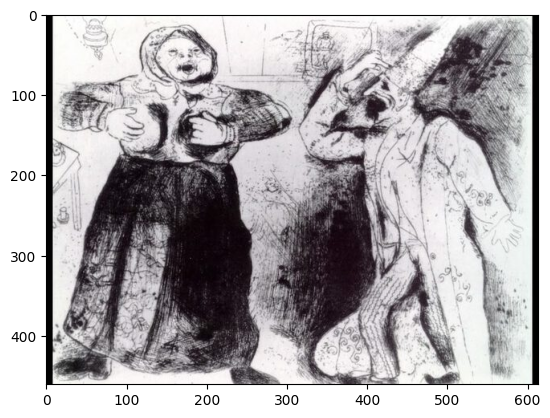

In [31]:
test_painting = painting("local DB",random.choice(unused_paintings))
print(test_painting.id)
test_ndarray = cv.resize(test_painting.ndarray, dsize=(PIXEL_SIZE,PIXEL_SIZE)
                               ,interpolation=cv.INTER_CUBIC)
test_ndarray = test_ndarray/255
temp_array = np.zeros((1,PIXEL_SIZE,PIXEL_SIZE,3))
print(temp_array.shape)
temp_array[0] = test_ndarray
prediction = model.predict(temp_array)
np.set_printoptions(suppress=True)
print(np.round(prediction, 4))
print(np.argmax(prediction))
index = np.argmax(prediction)
print(f"Prediction is {class_names[index]}")

art_id = gallery.get_painting(test_painting.id)[1]
print("Correct is ", gallery.get_artist(art_id)[1])

imgplot = plt.imshow(test_painting.ndarray)
plt.show()